# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [1]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [2]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

# Import other modules
import numpy as np
import math
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

%config InlineBackend.figure_format = "retina"

## Step 0: **Define** the (classical) problem

In [26]:
prob = generate_problem(n=32, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")
print()
print(np.linalg.eigvalsh(A))

A: [[ 4.91559363e-01  3.80252637e-02  4.89503029e-17 ... -4.64254065e-02
  -1.54916584e-16  1.92127476e-02]
 [ 3.80252637e-02  3.59822713e-01 -4.92284297e-17 ... -1.40175867e-16
  -7.45379613e-17  1.76192887e-03]
 [ 4.89503029e-17 -4.92284297e-17  3.98740210e-01 ...  2.50870303e-16
   2.36692786e-02 -3.90768043e-17]
 ...
 [-4.64254065e-02 -1.40175867e-16  2.50870303e-16 ...  5.58894231e-01
   1.02420165e-16  5.61815977e-17]
 [-1.54916584e-16 -7.45379613e-17  2.36692786e-02 ...  1.02420165e-16
   5.10919463e-01  5.11057850e-18]
 [ 1.92127476e-02  1.76192887e-03 -3.90768043e-17 ...  5.61815977e-17
   5.11057850e-18  3.46029955e-01]]

b: [ 0.09016874 -0.10265272  0.16694162  0.07241834  0.44183625 -0.1876702
  0.10258693 -0.22995711 -0.12528504  0.12094732 -0.47073364 -0.15374502
 -0.17163946 -0.03537842  0.00556788 -0.16075951 -0.15641436 -0.06005417
  0.01854396 -0.21442375 -0.00347768 -0.11934269 -0.04675718 -0.08489916
  0.19291747  0.22804872 -0.20216868 -0.20627538  0.04830592  0.13

## Step 1: **Map** problem to quantum circuits and operators

In [4]:
hhl = HHL(
    state_prep = StatePrep(method='default'),
    readout = 'measure_x',
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = int(math.log2(len(b))),
    t0 = 2 * np.pi)

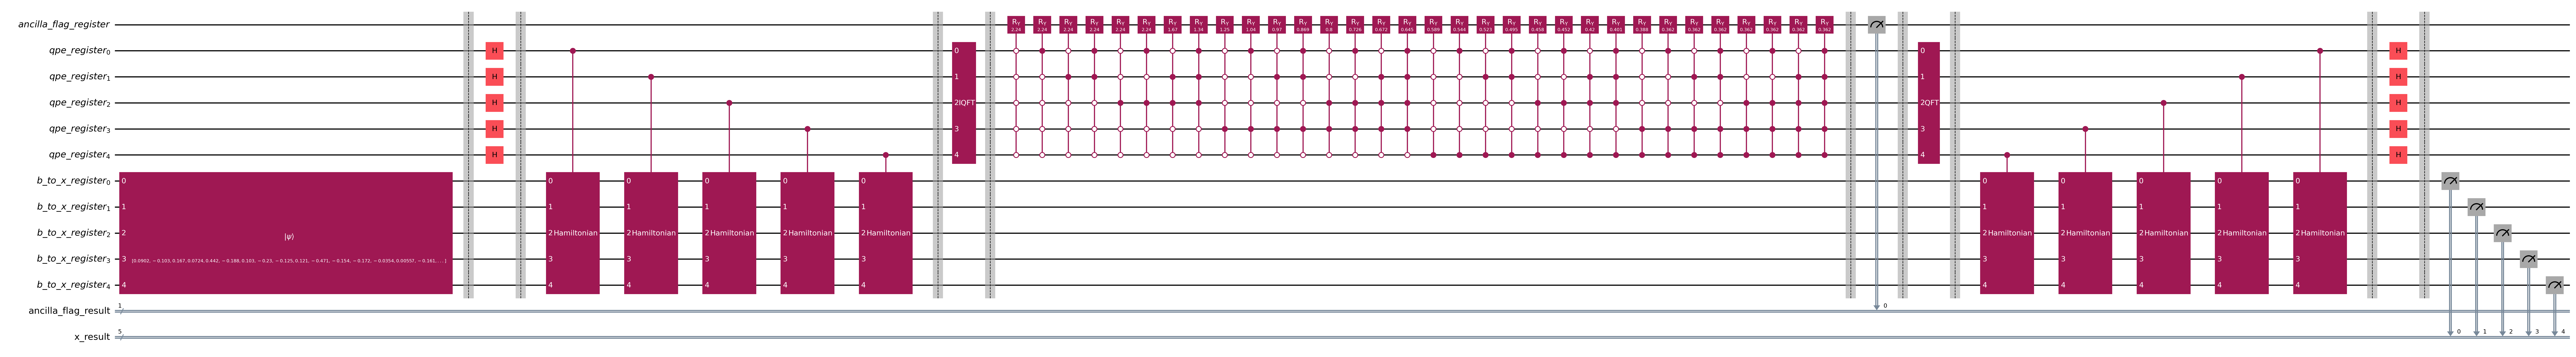

In [5]:
hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [6]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [7]:
# Define a backend

# use a specific hardware backend
# backend = service.backend("ibm_boston")

# or use the least busy backend
# backend = service.least_busy(operational=True, min_num_qubits=hhl_circuit.num_qubits)
# print("Backend: ", backend)

# or use a simulator
# noiseless:
backend = AerSimulator()

# noisy:
# Add depolarizing error to all single qubit u1, u2, u3 gates
# noise_model = NoiseModel()
# error_prob = .05
# error = depolarizing_error(error_prob, 1)
# noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
# backend = AerSimulator(noise_model=noise_model)

In [8]:
# Transpile the circuit

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        9948
2q-size:         10340
Operator counts: OrderedDict([('cu', 6800), ('ccx', 4440), ('cp', 2260), ('cx', 1280), ('p', 1138), ('u', 98), ('u3', 87), ('h', 20), ('barrier', 9), ('x', 6), ('measure', 6), ('initialize', 1)])


## Step 3: **Execute** on target hardware

In [9]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend,
    shots = 100
    )

>>> Job ID: d0f07edd-9998-4bb2-9b08-a33b353b9d5a
>>> Job Status: DONE      


## Step 4: **Process** result to obtain classical solution

In [10]:
processor = Post_Processor()
solution = processor.process(result, A, b)
solution

total shots: 100
num_successful_shots: 11
success rate: 0.11


array([ 0.        , -0.30151134,  0.        , -0.        ,  0.42640143,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.30151134, -0.        , -0.30151134,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.52223297, -0.30151134, -0.        , -0.        ,  0.        ,
       -0.42640143,  0.        ])

## Wrapping steps 1-4 together in a solver:

In [11]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    shots = 10000,
    optimization_level = 3,
    executer = executer,
    post_processor = processor,)
    #mode = "session")

## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: 1425300a-af43-4c77-8357-352be0587d12
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1823
success rate: 0.1823
  residual: 0.2807, error: 0.2270, alpha: 2.1544

IR Iteration: 1
>>> Job ID: 9e4606a2-f9c4-408b-8f01-6ae9df2cf402
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1145
success rate: 0.1145
  residual: 0.0890, error: 0.0669, alpha: 1.1253

IR Iteration: 2
>>> Job ID: 444035c6-c6e9-49c3-8ab8-80374afb265a
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 2144
success rate: 0.2144
  residual: 0.0411, error: 0.0410, alpha: 0.7161

IR Iteration: 3
>>> Job ID: a445cfb3-2e1a-43a7-8d79-f2f0bc30a6ac
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 2516
success rate: 0.2516
  residual: 0.0172, error: 0.0181, alpha: 0.9253

IR Iteration: 4
>>> Job ID: dda30fcf-a964-4018-a1c1-00af69130ac1
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 3565
success rate: 0.3565
  res

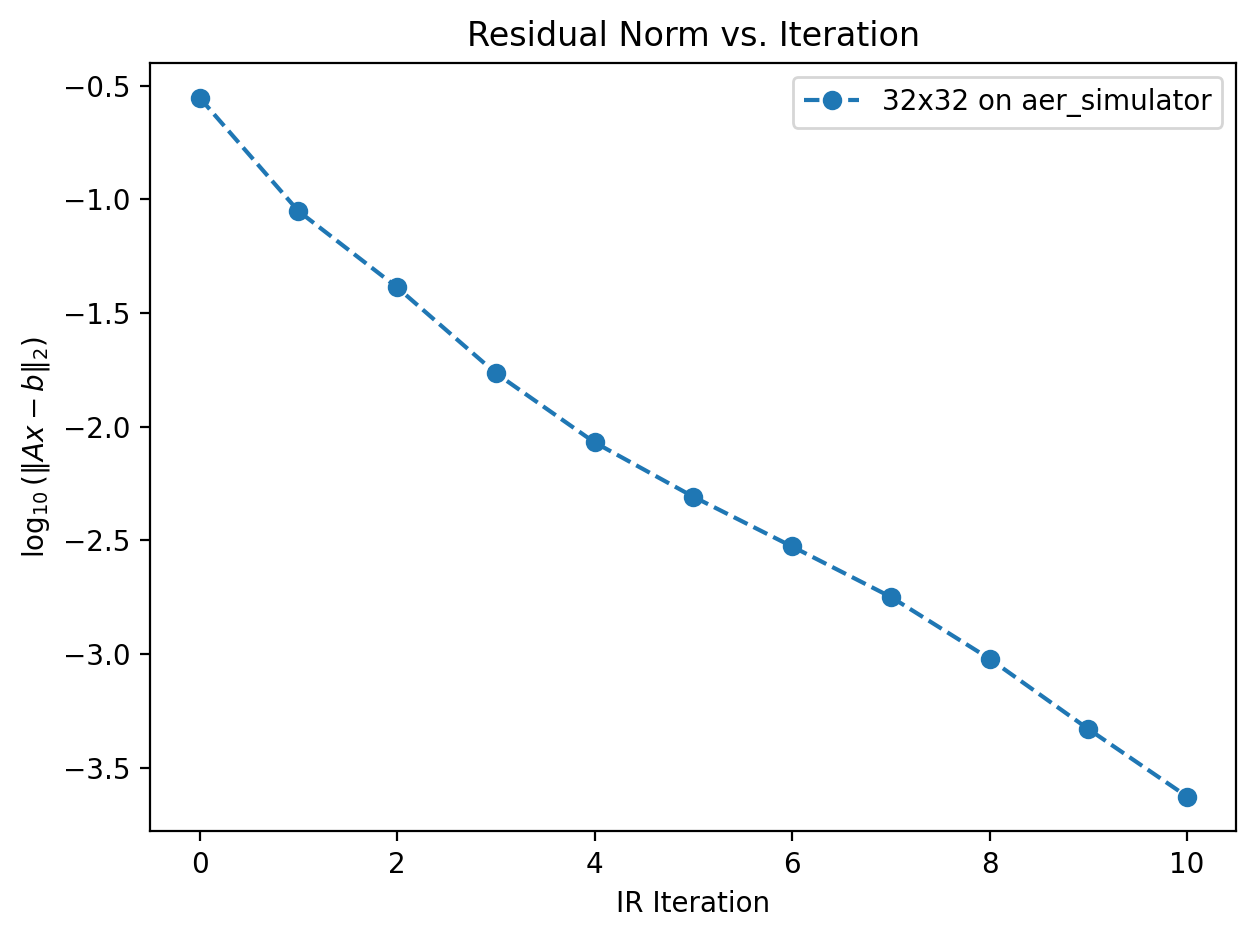

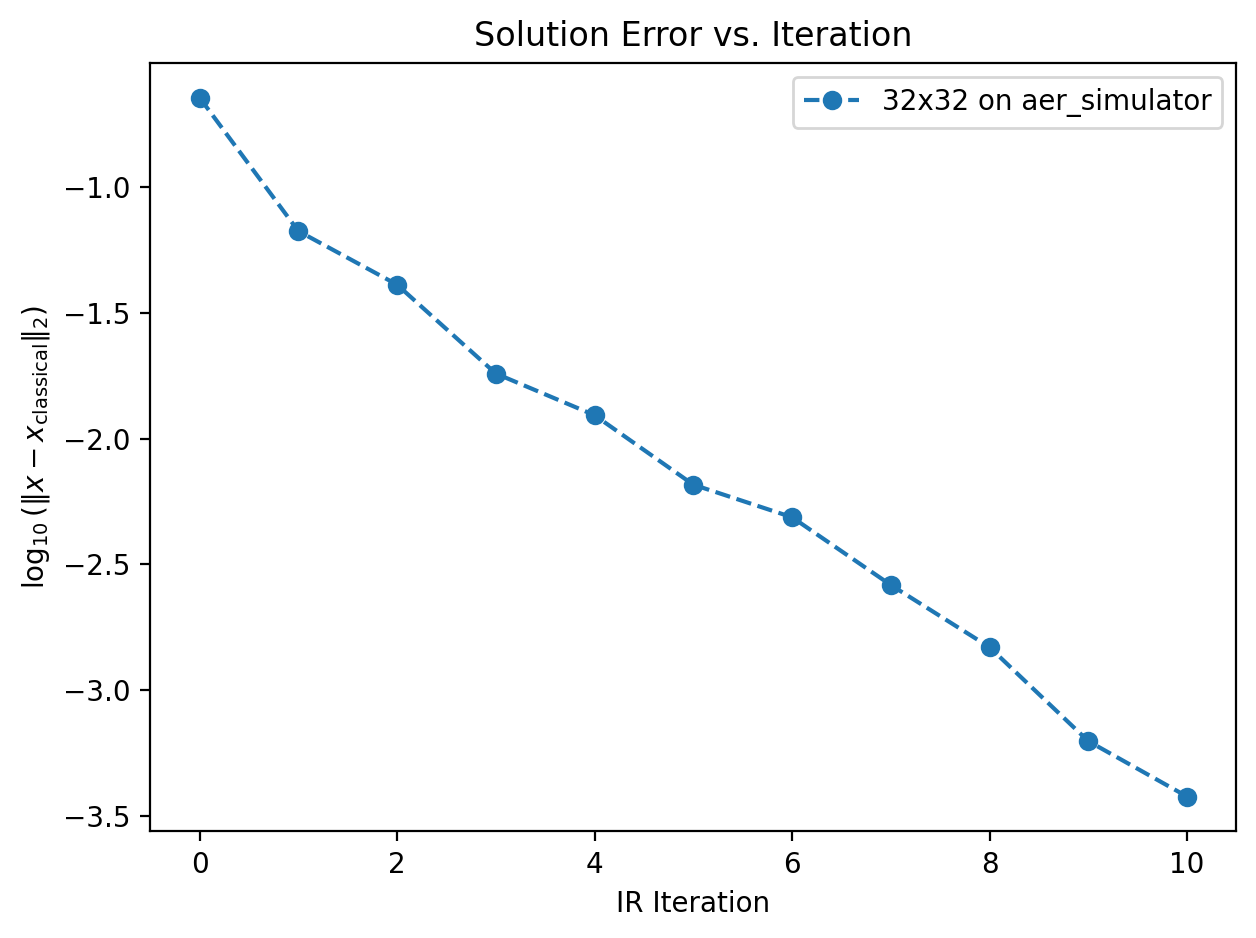

In [12]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)
refined_solution = refiner.refine(precision = 1e-9, max_iter = 10, plot=True)

In [24]:
import matplotlib.pyplot as plt

iterations = 10          # number of IR iterations to plot (0..iterations-1)
n = 32
max_qpe_qubits = 6      # sweep num_qpe_qubits = 1..max_qpe_qubits

# rows: qpe qubits, cols: IR iteration
residuals = np.full((max_qpe_qubits, iterations), np.nan, dtype=float)

prob = generate_problem(n=n, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]
A = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

for qpe_qubits in range(1, max_qpe_qubits + 1):
    print(f"================num_qpe_qubits: {qpe_qubits}=================")
    solver = QuantumLinearSolver(
        qlsa=HHL(
            state_prep=StatePrep(method="default"),
            readout="measure_x",
            num_qpe_qubits=qpe_qubits,
            t0=2 * np.pi,
        ),
        backend=AerSimulator(),
        shots=10000,
        optimization_level=3,
        executer=executer,
        post_processor=processor,
    )

    refiner = Refiner(A=A, b=b, solver=solver)
    refined_solution = refiner.refine(precision=1e-20, max_iter=iterations - 1, plot=False)

    r = np.asarray(refined_solution["residuals"], dtype=float)
    residuals[qpe_qubits - 1, : len(r)] = r

# heatmap of log10 residuals
log_residuals = np.log10(np.maximum(residuals, 1e-16))

================num_qpe_qubits: 1=================
IR Iteration: 0
>>> Job ID: bccf608d-e509-4047-992f-515489a0b344
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 3652
success rate: 0.3652
  residual: 0.4555, error: 0.4812, alpha: 1.5668

IR Iteration: 1
>>> Job ID: 99467ba1-27e1-438e-81f6-f5c6a97afd23
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 3626
success rate: 0.3626
  residual: 0.2549, error: 0.1954, alpha: 1.6796

IR Iteration: 2
>>> Job ID: a608cd9c-2ff2-4b75-9092-d2ba8f4ecc7b
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 3686
success rate: 0.3686
  residual: 0.1202, error: 0.0874, alpha: 2.2734

IR Iteration: 3
>>> Job ID: 8a10d243-e839-43b7-b711-aed84c407f0e
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 4174
success rate: 0.4174
  residual: 0.0680, error: 0.0569, alpha: 1.6240

IR Iteration: 4
>>> Job ID: 64a684b0-c43f-455c-a4aa-0cc02a76a0d0
>>> Job Status: DONE      
total shots: 10000
nu

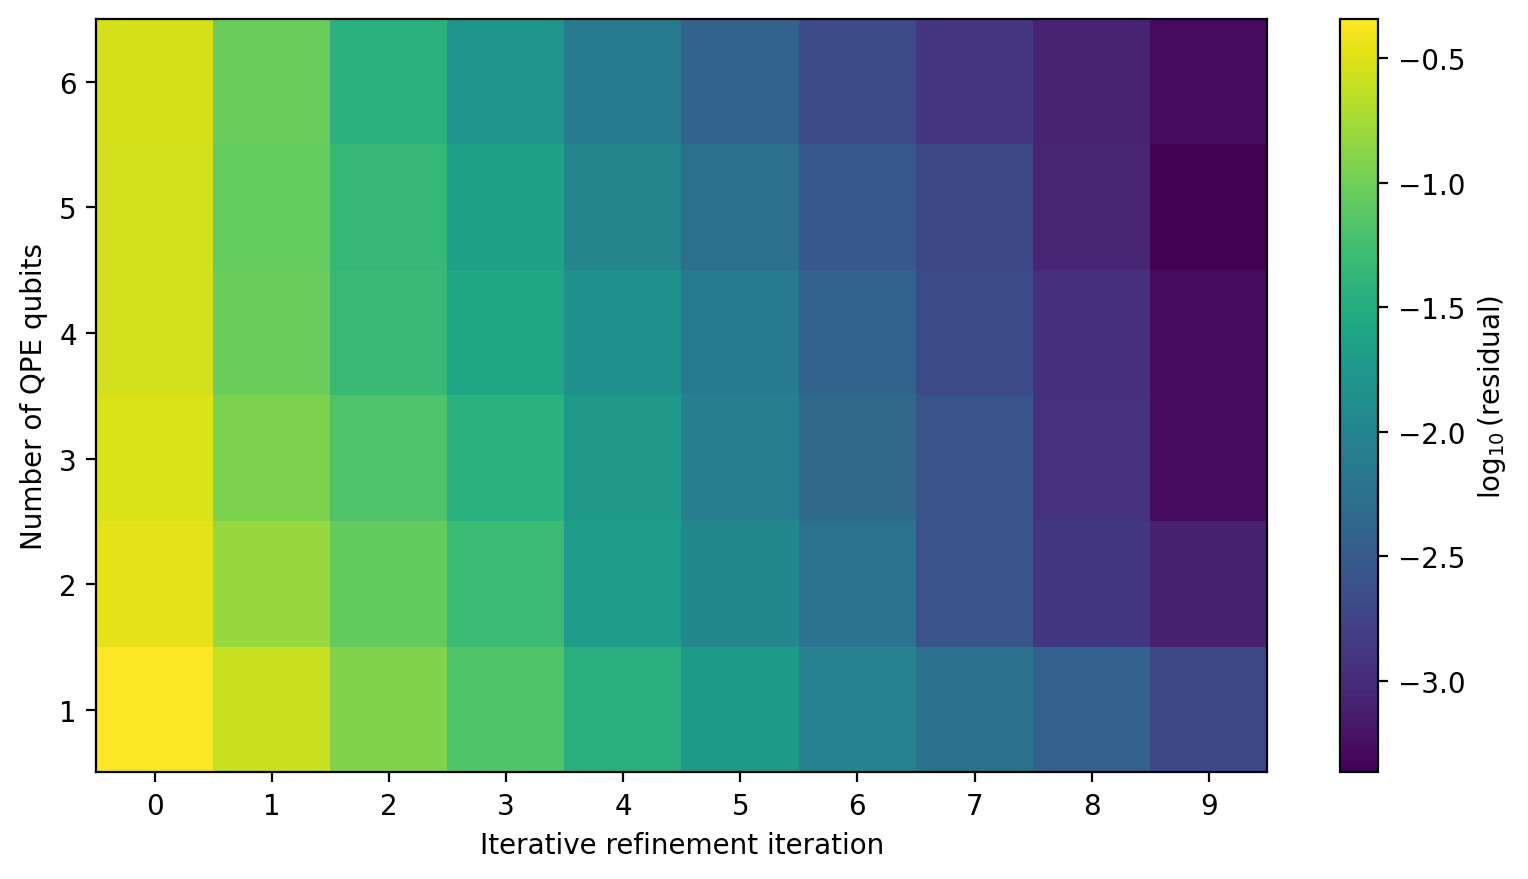

In [25]:
fig, ax = plt.subplots(figsize=(8, 4.5))
im = ax.imshow(
    log_residuals,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    interpolation="nearest",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Number of QPE qubits")

ax.set_xticks(np.arange(iterations))
ax.set_yticks(np.arange(max_qpe_qubits))
ax.set_yticklabels(np.arange(1, max_qpe_qubits + 1))

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\log_{10}(\mathrm{residual})$")
# cbar.set_label(r"$\mathrm{residual}$")

plt.tight_layout()
plt.show()